# Introduction to Time Series with Python

Lesson Goals

In this lesson we will discover the branch of statistics that deals with time ordered data, also known as time series. We will learn about the different types of time series, about correlation and auto-correlation, and about different prediction methods for time series data.
Introduction

So far we have studied data that is static in time. This was important since many models require that we assume that observations are independent of one another. However, when dealing with time ordered data, many times this assumption is no longer valid. For example, the temperature observed today is not independent of the temperature yesterday. Another example is the stock market. Today's stock prices are related to yesterday's stock prices. In this lesson we will explore how to deal with data that contains such relationships
Time Series Decomposition

One of the ways to overcome the issues caused by having a relationship between the observations is to decompose the data into components. Typically, we split the data into two types of components - systematic and non-systematic.

    Systematic components are components that can have consistency or recurrence.
    Non-systematic components cannot be modeled.

We can typically decompose a time series into 4 components - 3 systematic components and one noise component.:

    The mean of the series
    The seasonality or cyclical pattern of the series
    The trend of the series - this component is what we would like to model
    The noise is typically the random variation in our data

Time Series Decomposition in Python

We will focus on the statsmodels library for modeling and plotting time series data in Python. statsmodels contains a function called seasonal_decompose that will allow us to plot the decomposed time series data.

In [1]:
import pandas as pd

In [2]:
occupancy = pd.read_csv('../occupancy.csv')
occupancy.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2/2/2015 14:00,23.7000,26.272,585.200000,749.200000,0.004764,1
1,2/2/2015 15:00,23.7180,26.290,578.400000,760.400000,0.004773,1
2,2/2/2015 16:00,23.7300,26.230,572.666667,769.666667,0.004765,1
3,2/2/2015 17:00,23.7225,26.125,493.750000,774.750000,0.004744,1
4,2/2/2015 18:00,23.7540,26.200,488.600000,779.000000,0.004767,1


To plot this data, we must make sure our index is a time series with a known frequency. To analyze time series data, the data needs to be equally spaced. In the code below, we will change the type of the date column to datetime and change the index to the date column. Our frequency is 1 hour. Even though we can see that the difference between observation is 1 hour, it is not inferred, and we need to specify it ourselves. To read more about frequencies, look [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases).

In [3]:
occupancy.date = pd.to_datetime(occupancy.date)
occupancy.index = pd.DatetimeIndex(occupancy.date, freq='H')
occupancy.index

DatetimeIndex(['2015-02-02 14:00:00', '2015-02-02 15:00:00',
               '2015-02-02 16:00:00', '2015-02-02 17:00:00',
               '2015-02-02 18:00:00', '2015-02-02 19:00:00',
               '2015-02-02 20:00:00', '2015-02-02 21:00:00',
               '2015-02-02 22:00:00', '2015-02-02 23:00:00',
               ...
               '2015-05-24 04:00:00', '2015-05-24 05:00:00',
               '2015-05-24 06:00:00', '2015-05-24 07:00:00',
               '2015-05-24 08:00:00', '2015-05-24 09:00:00',
               '2015-05-24 10:00:00', '2015-05-24 11:00:00',
               '2015-05-24 12:00:00', '2015-05-24 13:00:00'],
              dtype='datetime64[ns]', name='date', length=2664, freq='H')

Now we can plot the decomposed time series.

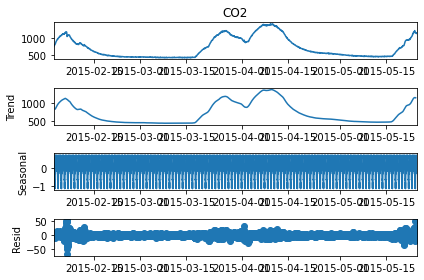

In [4]:
import statsmodels.api as sm

res = sm.tsa.seasonal_decompose(occupancy.CO2)
resplot = res.plot()

# Autoregression

An autoregressive model is a model that uses previous observations in the time series to predict the next value in the model. In previous lessons, we have looked at linear models where the response variable depends only on the predictor variables and the linear regression equation.
However, when working with time series data, our response variable depends not only on the predictor variables but also on the response variable itself. A variable that depends on itself is called an autocorrelated variable. Our model can also depend on more than one time period in the past.


# Checking for Autocorrelation

We can check for autocorrelation in our data using a lag plot. This plot will plot y t against y t-1. Pandas has a function called lag_plot for detecting these relationships.

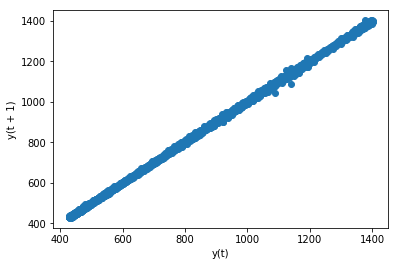

In [5]:
from pandas.plotting import lag_plot

lag_plot(occupancy.CO2);

A line along the diagonal shows that there is an autoregressive relationship.

To create an autoregressive model we use the AR function. Typically, we note an autoregressive model with the notation AR(n) where n is the number of lag periods. In the example below, we will create an autoregressive model with lag 1 to model the rate of CO2. In the example below, we limit the lag periods to 1. However, if we do not set a limit, the model may contain more lag periods.

Note that we split the data into test and train and always use the last few observations when working with time series data. We do this to ensure that the model gives good predictions even on data it has not seen. Since the data is ordered, we cannot select the test data at random.

In [5]:
from statsmodels.tsa.ar_model import AR

train, test = occupancy.CO2[:-10], occupancy.CO2[-10:]
model = AR(occupancy.CO2)
model_fit = model.fit(maxlag=1)
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

/home/brida/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:791: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarni

Like linear regression, this model produces coefficients for the autoregressive model as well as predictions.

In [6]:
print(model_fit.params)

const     0.001078
L1.CO2    1.000195
dtype: float64


In [7]:
pd.DataFrame({'observed':test, 'predicted':predictions})

,observed,predicted
date,,
2015-05-24 04:00:00,1153.250000,1152.725379
2015-05-24 05:00:00,1152.400000,1153.475525
2015-05-24 06:00:00,1146.166667,1152.625359
2015-05-24 07:00:00,1145.400000,1146.390813
2015-05-24 08:00:00,1140.800000,1145.623997
2015-05-24 09:00:00,1150.250000,1141.023102
2015-05-24 10:00:00,1129.200000,1150.474941
2015-05-24 11:00:00,1125.800000,1129.420844
2015-05-24 12:00:00,1123.000000,1126.020182


# Stationarity

A time series is considered stationary if its mean and variance do not vary over time. While we cannot consider a stationary time series to be independent, stationarity is a dependence structure that can help us with a number of modeling techniques. To check whether we have a stationary time series, we can either examine the decomposition plot visually, compute the mean and standard deviation over time, or use statistical tests. One possible test is the Augmented Dickey-Fuller test. This test has the following hypothesis:

H 0: The data is not stationary

H 1: The data is stationary

We test stationarity using the adrfuller function in statsmodels. The example below demonstrates this with our CO2 data. The adrfuller function returns multiple values. The second position in the data structure returned is the p-value of our hypothesis.

In [8]:
from statsmodels.tsa.stattools import adfuller

adfuller(occupancy.CO2)[1]

0.06822624483241008

The p-value is greater than 0.05. Therefore, with a 95% confidence interval, we do not reject the null hypothesis and conclude that the data is not stationary.


# Random Walks

A random walk is a type of time series model where each observation depends on the sum of the previous observation and a random noise component. 

Random walks are considered non-stationary because the covariance between observations is time dependent.

# Moving Average

Moving average models are similar to autoregressive models. Moving average models also depend on a linear combination of past data. However, unlike autoregressive models, these models depend on past white noise terms. While the name is the same, moving average models are not the same as calculating the moving average of a time series.

Moving average models are typically noted with MA(q) where q is the number of past white noise terms summed by the model.
Note that the errors are normally distributed with mean 0 and variance σ ω.

We can create a moving average model using the ARMA function in the statsmodels package. This function generates models that can have both an autoregressive component as well as a moving average component. However, here we will set the autoregressive lag to zero to create only a moving average model. Let's use our CO2 data again for this example.

In [9]:
from statsmodels.tsa.arima_model import ARMA

model = ARMA(occupancy.CO2, order=(0, 1))
model_fit = model.fit(disp=False)
predictions = model_fit.predict(len(occupancy.CO2)-3, len(occupancy.CO2)-1)

/home/brida/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Let's look at the predictions:

In [11]:
pd.DataFrame({'observed':occupancy.CO2[-3:], 'predicted':predictions})

,observed,predicted
date,,
2015-05-24 11:00:00,1125.8,926.766779
2015-05-24 12:00:00,1123.0,915.383218
2015-05-24 13:00:00,1124.0,923.901347


We can see that this model alone is not a great fit for this data since there is a big difference between observed and predicted.


# Combining Autoregression with Moving Average

As we have seen in the previous paragraph, we can create a model with both an autoregressive component and a moving average component. This model is called an ARMA model and is denoted by ARMA(n, q) where n is the number of lag periods and q is the number of past white noise terms. Below is an example of an ARMA model with two lag terms and one white noise term.



In [12]:
from statsmodels.tsa.arima_model import ARMA

# fit model
model = ARMA(occupancy.CO2, order=(2, 1))
model_fit = model.fit(disp=False)
# make prediction
predictions = model_fit.predict(len(occupancy.CO2)-3, len(occupancy.CO2)-1)

/home/iudh/.local/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


We expect our predictions to improve:

In [13]:
pd.DataFrame({'observed':occupancy.CO2[-3:], 'predicted':predictions})

,observed,predicted
date,,
2015-05-24 11:00:00,1125.8,1128.228229
2015-05-24 12:00:00,1123.0,1124.664951
2015-05-24 13:00:00,1124.0,1121.746877
